## NOTE
This notebook code has been written in a mostly procedural format.  This is so that I can demonstrate my thought process and decision making in a clear and logical way.  This code would need some re-factoring once I'm happy with my final solution, before thinking about getting it to a production ready format if required.

I have used 'Black' code reformatter to ensure the style is PEP 8 compliant.

In [1]:
%load_ext nb_black
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# always reload modules so that as you change code in src, it gets loaded
%autoreload 2

<IPython.core.display.Javascript object>

In [7]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from rfpimp import plot_corr_heatmap


from dotenv import find_dotenv, load_dotenv

load_dotenv()

True

<IPython.core.display.Javascript object>

In [8]:
os.getcwd()

'C:\\Users\\mshar\\work\\store-sales-model\\notebooks'

<IPython.core.display.Javascript object>

## Data Loading

In [11]:
# define project path using environment variable (stored locally)
project_path = os.environ["PROJPATH"]

# define dataset file paths
train_path = os.path.join(project_path, "train.csv")
test_path = os.path.join(project_path, "test.csv")

# load CSV files
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

<IPython.core.display.Javascript object>

In [12]:
# view contents to check file has been loaded correctly
train.head(5)

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97


<IPython.core.display.Javascript object>

In [13]:
# view contents to check file has been loaded correctly
test.head(5)

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,county
0,105,0.039968,34.0,6.09,no,4.15,3.590,59.6,5.4917,Many transport options,329,16.1,395.75,2.3750,c_42
1,400,0.587758,20.0,3.97,no,14.85,5.398,8.5,2.2885,Average transport options,264,13.0,386.86,1.4775,c_140
2,338,1.116926,0.0,8.14,no,9.40,2.813,0.0,4.0952,Few transport options,307,NaN,394.54,4.9700,c_55
3,227,1.517409,0.0,19.58,no,12.75,3.066,0.0,1.7573,Average transport options,403,14.7,353.89,1.6075,c_62
4,114,83.093533,0.0,18.10,no,16.45,2.957,0.0,1.8026,All transport options,666,20.2,16.45,5.1550,c_22


<IPython.core.display.Javascript object>

In [7]:
# one less column in the test dataset
print(train.shape)
print(test.shape)

(320, 16)
(13, 15)


<IPython.core.display.Javascript object>

In [8]:
# check which column(s) differ between datasets
train_columns = list(train.columns.values)
test_columns = list(test.columns.values)
set(train_columns) - set(test_columns)

{'normalised_sales'}

<IPython.core.display.Javascript object>

In [9]:
# descriptive statistics for each column
train.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,normalised_sales
count,320.000000,320.000000,320.000000,320.000000,291.000000,320.000000,320.000000,320.000000,320.000000,257.000000,320.000000,320.000000,320.000000
mean,252.387500,3.596375,10.673438,11.307906,16.868557,3.252803,31.849063,3.718765,408.834375,18.589494,359.657562,3.144008,-0.016967
std,145.600582,7.176342,22.579232,7.032693,73.806051,0.695442,27.845777,1.984765,170.888974,2.075529,86.048632,1.774041,0.978561
min,1.000000,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,188.000000,13.000000,3.500000,0.432500,-1.936974
25%,126.500000,0.087937,0.000000,5.130000,5.450000,2.879750,6.350000,2.138075,277.000000,17.400000,376.722500,1.803750,-0.585250
50%,251.500000,0.289681,0.000000,9.900000,9.400000,3.197500,23.400000,3.095750,330.000000,19.100000,392.205000,2.808750,-0.143759
75%,377.250000,4.063553,12.500000,18.100000,14.050000,3.597250,54.450000,5.116700,666.000000,20.200000,396.352500,4.091875,0.243227
max,506.000000,51.693093,100.000000,27.740000,1009.000000,5.725000,94.000000,10.710300,711.000000,21.200000,396.900000,9.492500,2.968477


<IPython.core.display.Javascript object>

In [10]:
# check the distribution in the test dataset also
# we need to check that when making predictions the model isapplied to stores that follow a similar distribution
test.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency
count,13.000000,13.000000,13.000000,13.000000,12.000000,13.000000,13.000000,13.000000,13.000000,11.000000,13.000000,13.000000
mean,235.615385,8.740234,11.076923,10.938462,11.129167,3.581077,29.915385,3.492546,420.230769,17.772727,354.753077,2.755962
std,136.941921,22.651266,25.918017,6.326023,5.865595,0.860942,35.797785,1.953115,176.230509,2.684806,102.742778,1.599229
min,12.000000,0.010238,0.000000,2.970000,2.500000,2.813000,0.000000,1.129600,233.000000,13.000000,16.450000,0.617500
25%,136.000000,0.159895,0.000000,6.200000,6.587500,3.066000,2.800000,2.065100,287.000000,15.700000,383.370000,1.477500
50%,203.000000,0.650078,0.000000,8.140000,11.075000,3.297000,10.400000,2.368200,329.000000,17.900000,385.960000,2.220000
75%,341.000000,5.751892,0.000000,18.100000,16.037500,3.590000,59.600000,5.415900,666.000000,20.200000,393.680000,4.317500
max,477.000000,83.093533,90.000000,19.580000,19.500000,5.398000,93.400000,7.307300,666.000000,20.900000,395.750000,5.155000


<IPython.core.display.Javascript object>

In [11]:
# 320 stores in train data and 13 stores in test data
# columns have the same description in each dataset
# test data does not include target value, hence use train data for training, validation and testing
# test data will be used for predictions only
df = train.copy()
df["data"] = "train"
predict = test.copy()
predict["data"] = "predict"

%store df
%store predict

Stored 'df' (DataFrame)
Stored 'predict' (DataFrame)


<IPython.core.display.Javascript object>

## Data Exploration
 - Feature Identification
- Which are the features and which is the target value?
- What are the data types (character/numeric) and categories of the features (categorical/continuous)?
 - Univariate Analysis
 - Bivariate Analysis
 - Missing values
- Which features have missing values?
- Why might these values be missing?
- Can the missing data be sourced?
- How should we replace the missing values?
 - Outliers
- What is the cause of the outlier?
- Is it a 'true' outlier or a data collection error?
- How should we treat outliers?
 - Correlated features
- Which features can be dropped?
 - High cardinality features
 - Correlation with target

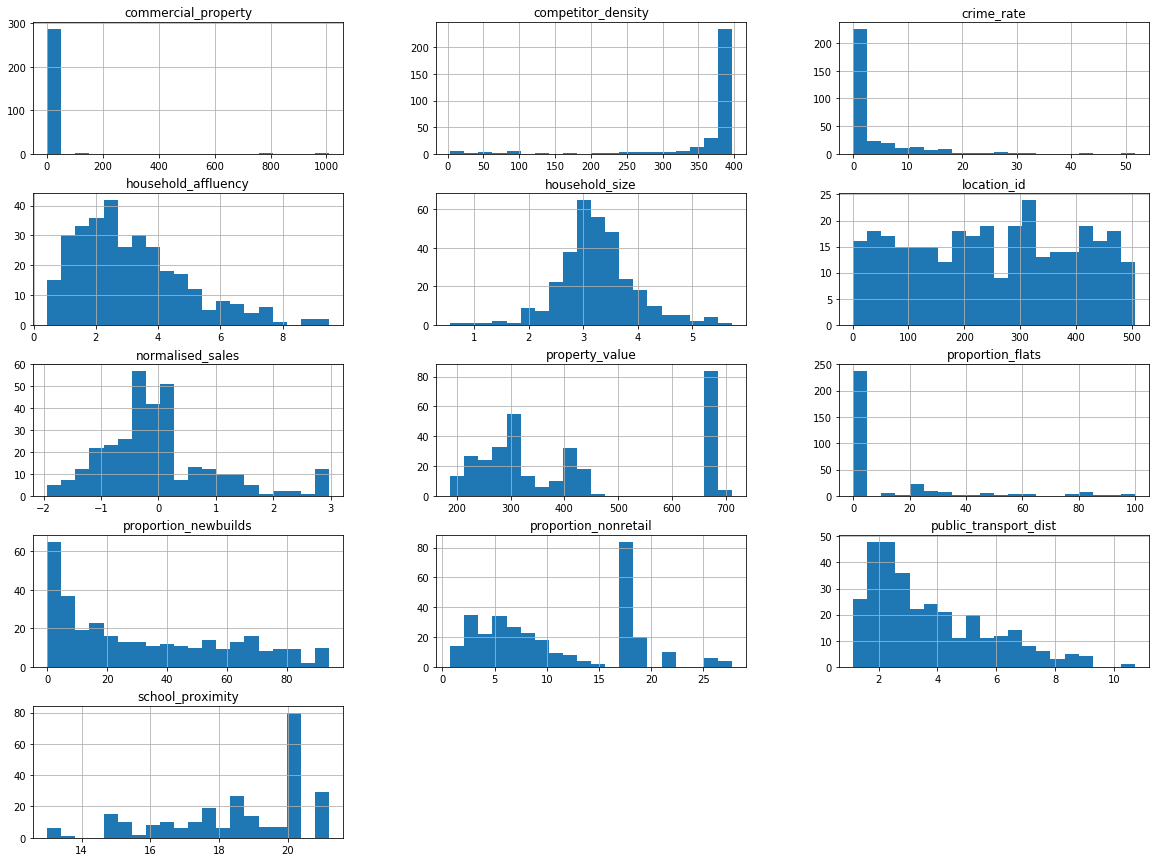

<IPython.core.display.Javascript object>

In [12]:
df_explore = df.copy()

# allow scroll-bar on charts
CSS = (
    """div.output_area img {max-width:None !important;max-height: None !important";}"""
)
display(HTML("<style>{}</style>".format(CSS)))

# check distribution of numeric features
numeric_features = df_explore.select_dtypes(include=["int64", "float64"]).columns
df_explore[numeric_features].hist(bins=20, figsize=(20, 15), layout=(5, 3))
plt.show()

In [13]:
# check the correlation of each feature against the target
# the low correlation score for location_id shows that it will not be a good feature
df_explore.corr()["normalised_sales"].sort_values(ascending=False)

normalised_sales         1.000000
household_size           0.692506
proportion_newbuilds     0.380474
proportion_flats         0.355756
competitor_density       0.338284
public_transport_dist    0.268658
location_id              0.040270
commercial_property     -0.065091
crime_rate              -0.445005
school_proximity        -0.447789
property_value          -0.463462
proportion_nonretail    -0.485237
household_affluency     -0.743277
Name: normalised_sales, dtype: float64

<IPython.core.display.Javascript object>

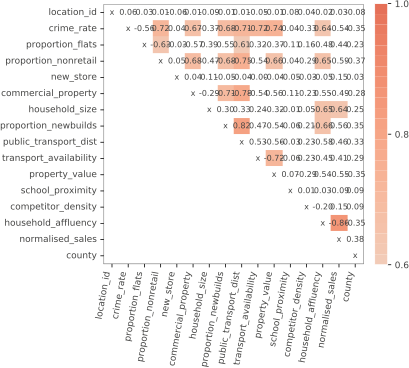

<IPython.core.display.Javascript object>

In [14]:
# check the intercorrelation between features
# proportion_newbuilds and public_transport_dist are highly correlated
viz = plot_corr_heatmap(df_explore.drop(columns=["data"]), figsize=(6, 6))
viz

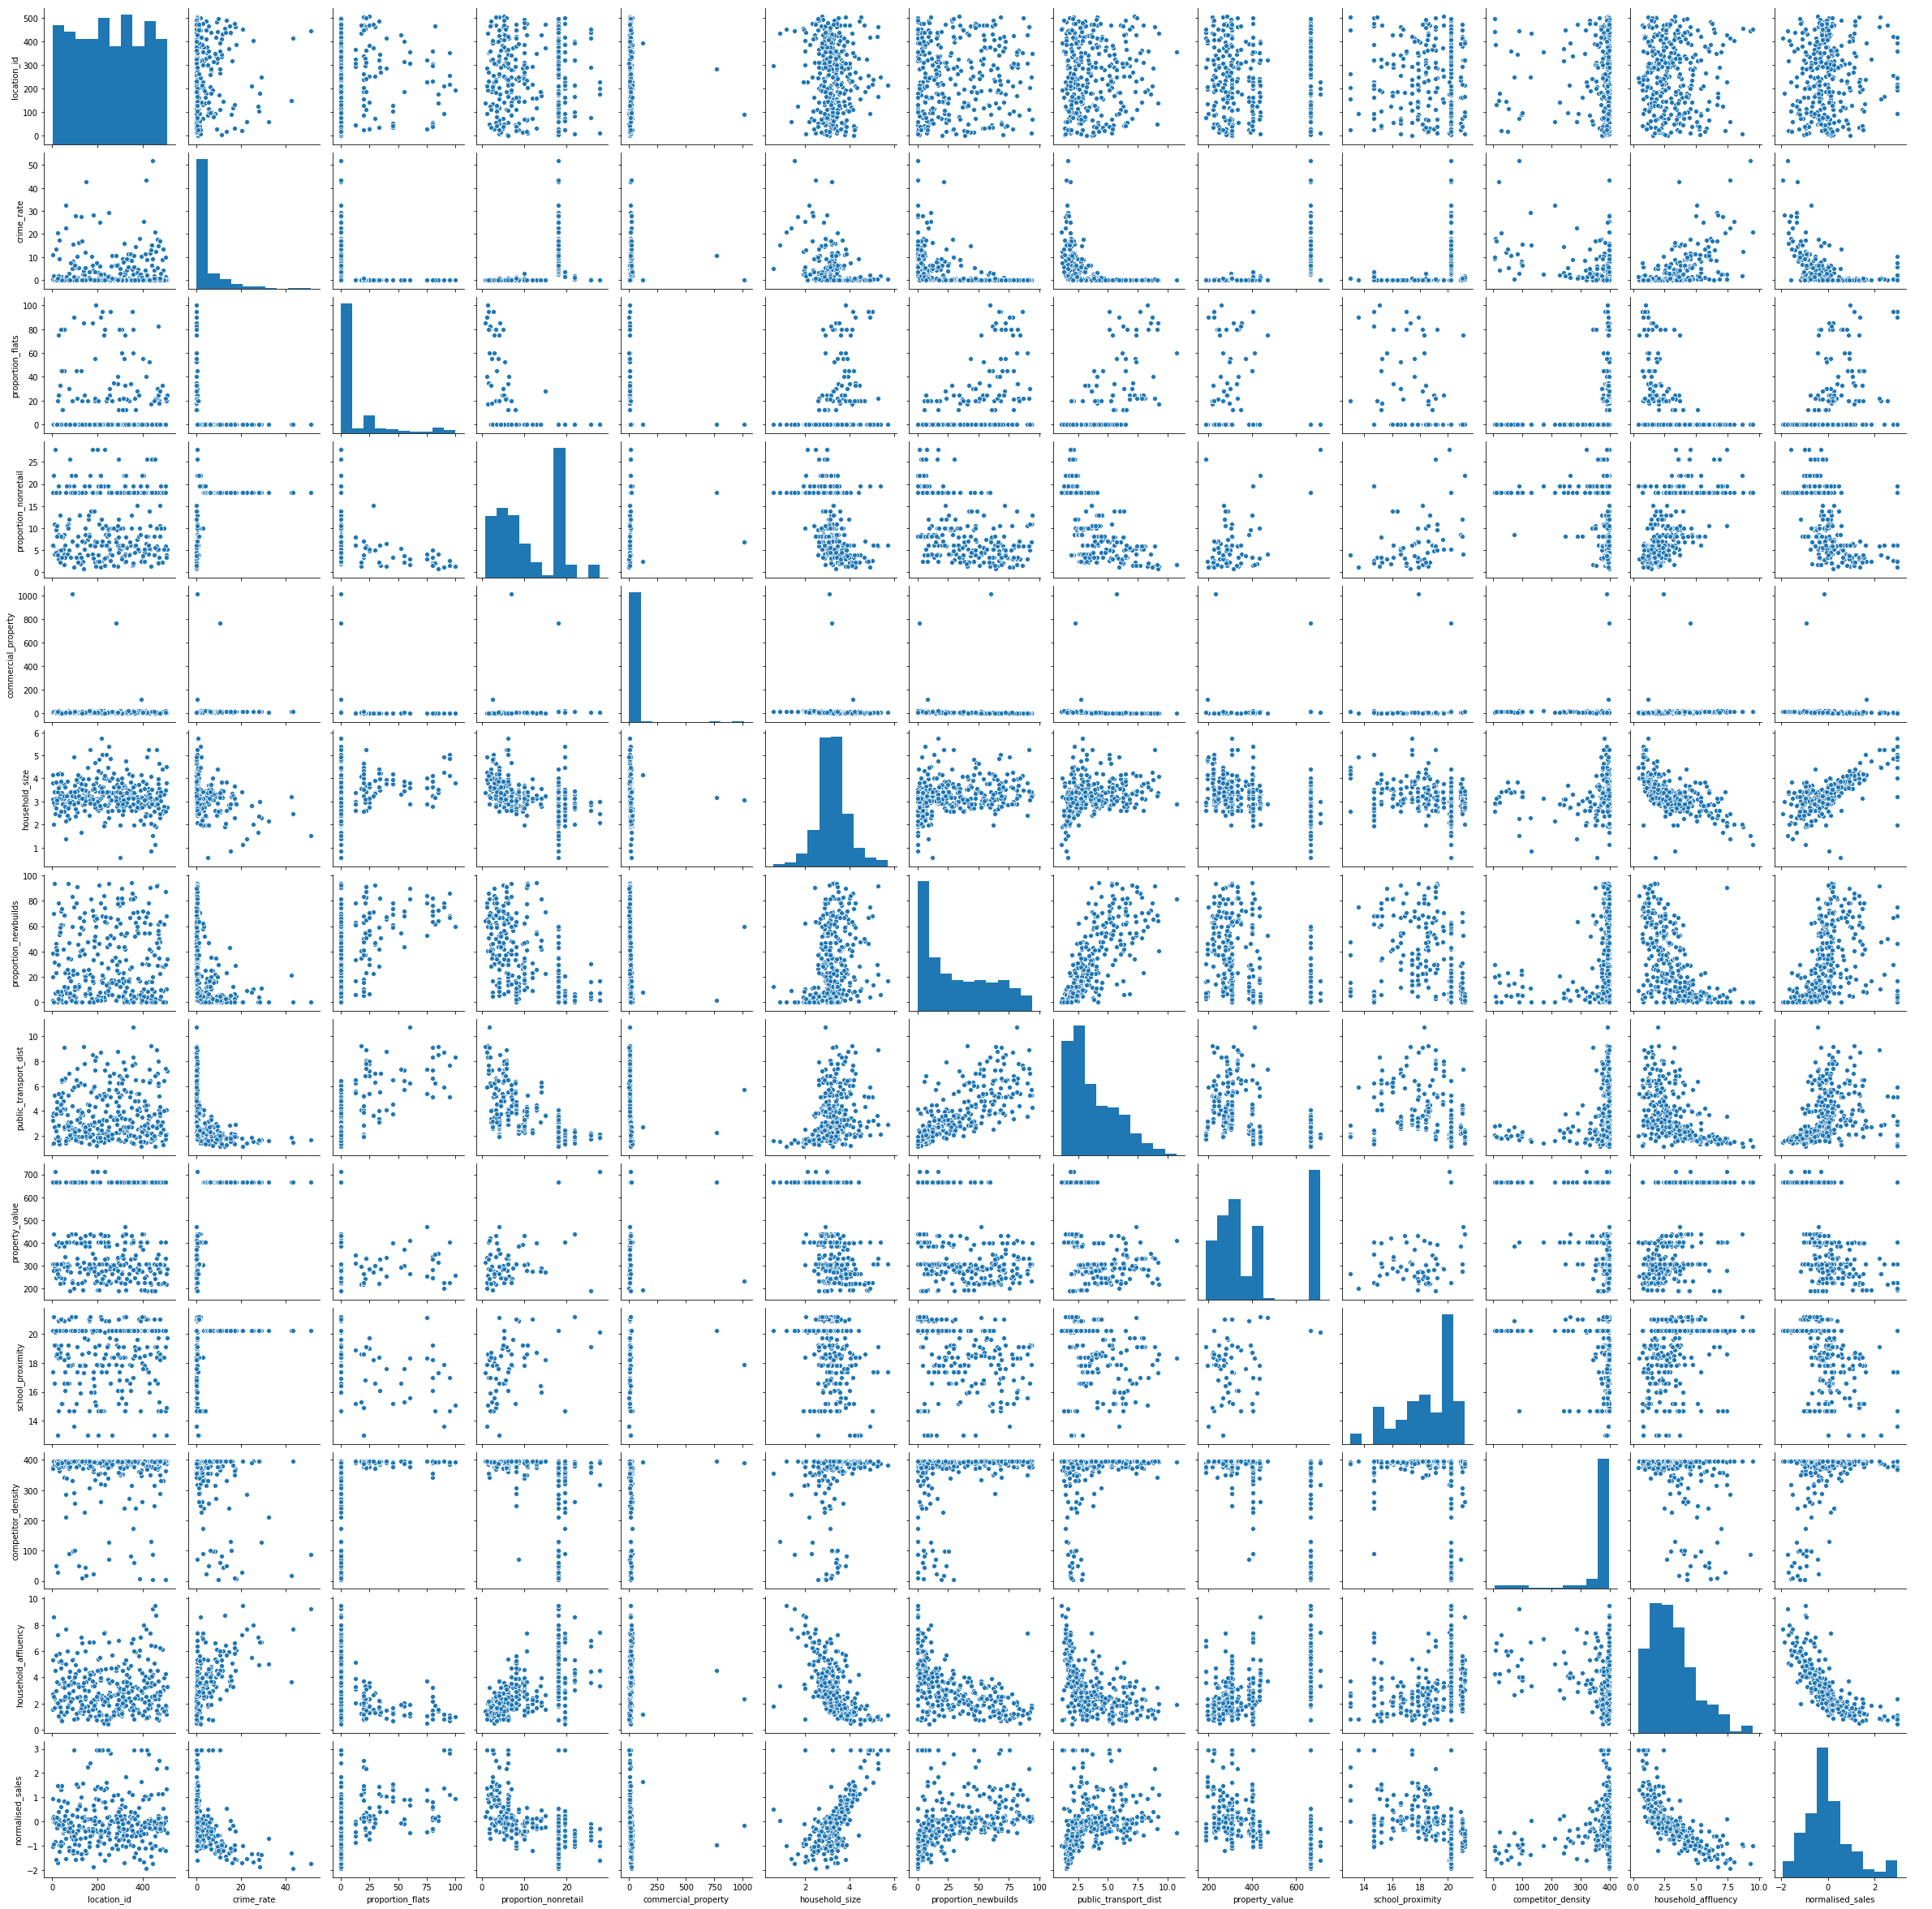

<IPython.core.display.Javascript object>

In [15]:
# check the pair-wise distribution between each feature
g = sns.pairplot(df_explore)

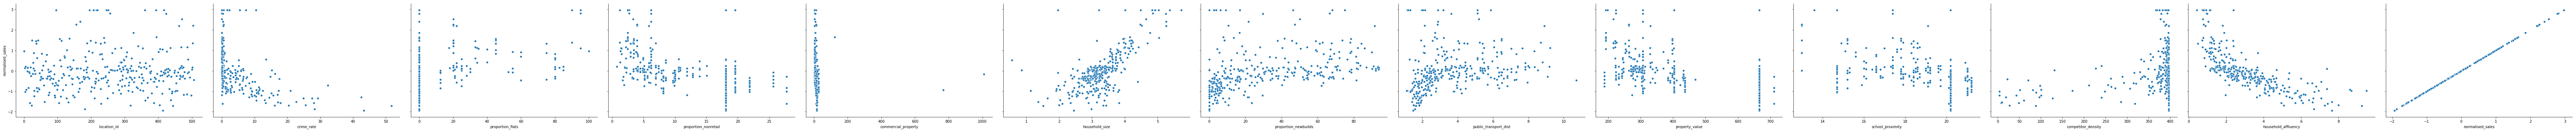

<IPython.core.display.Javascript object>

In [16]:
# check the distribution of each feature against the target
# household_size and household_affluency both show strong linear relationships
numeric_features = df_explore.select_dtypes(include=["int64", "float64"]).columns
g = sns.pairplot(
    df_explore, x_vars=numeric_features, y_vars="normalised_sales", height=4
)
g.fig.set_size_inches(100, 5)

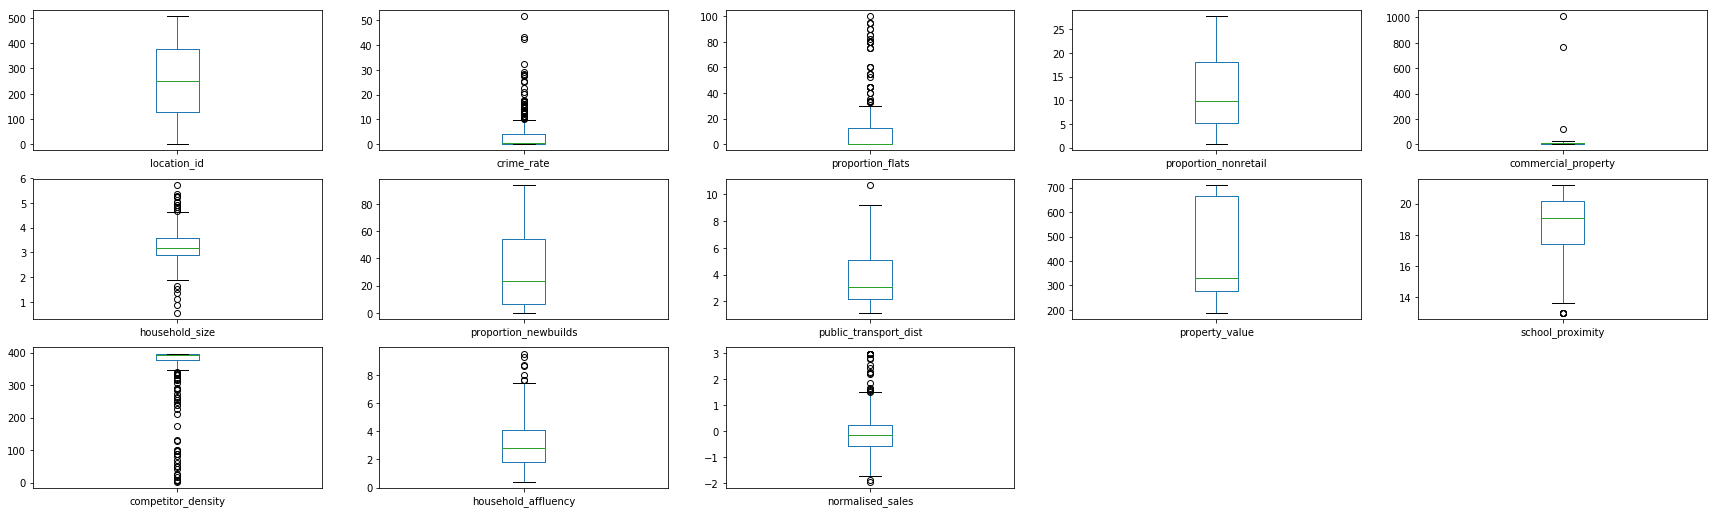

<IPython.core.display.Javascript object>

In [17]:
# check each feature for outliers
# crime_rate, competitor_density and commercial_property have very skewed distributions due to outliers
plt.rcParams["figure.figsize"] = (30.0, 15.0)
df_explore.plot(kind="box", subplots=True, layout=(5, 5), sharex=False, sharey=False)
plt.show()

In [18]:
# check for duplicates
dups = df_explore.duplicated()
# report if there are any duplicates
print(dups.any())

False


<IPython.core.display.Javascript object>

In [19]:
# check for missing values
# there exists a signficant proportion of missing values for commercial property and school proximity
# these are likely to be MCAR - Missing Completely At Random, i.e. no relationship between the missingness
# of the data and any values, observed or missing
# The missing values can be imputed using various diffent methods such as mean/median/mode, regression, KNN
df_explore.isnull().sum()

location_id                0
crime_rate                 0
proportion_flats           0
proportion_nonretail       0
new_store                  0
commercial_property       29
household_size             0
proportion_newbuilds       0
public_transport_dist      0
transport_availability     0
property_value             0
school_proximity          63
competitor_density         0
household_affluency        0
normalised_sales           0
county                     0
data                       0
dtype: int64

<IPython.core.display.Javascript object>

In [20]:
# check the dtypes for each column
# original dataframe with default dtypes takes 94.8KB
# 3 object (categorical) columns that need to be converted to numeric
df_explore.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 17 columns):
location_id               320 non-null int64
crime_rate                320 non-null float64
proportion_flats          320 non-null float64
proportion_nonretail      320 non-null float64
new_store                 320 non-null object
commercial_property       291 non-null float64
household_size            320 non-null float64
proportion_newbuilds      320 non-null float64
public_transport_dist     320 non-null float64
transport_availability    320 non-null object
property_value            320 non-null int64
school_proximity          257 non-null float64
competitor_density        320 non-null float64
household_affluency       320 non-null float64
normalised_sales          320 non-null float64
county                    320 non-null object
data                      320 non-null object
dtypes: float64(11), int64(2), object(4)
memory usage: 114.2 KB


<IPython.core.display.Javascript object>

In [21]:
# select just the object columns, display a sample row to get a better sense of how the values are formatted
object_columns_df = df_explore.select_dtypes(include=["object"])
print(object_columns_df.iloc[0])

new_store                                    no
transport_availability    All transport options
county                                     c_40
data                                      train
Name: 0, dtype: object


<IPython.core.display.Javascript object>

In [22]:
# new_store is a binary nominal categorical feature
# transport_availability is an ordinal categorical feature
# county is a high cardinality nominal categorical feature
cols = ["new_store", "transport_availability", "county"]
for name in cols:
    print(name, ":")
    print(object_columns_df[name].value_counts(), "\n")

new_store :
no     301
yes     19
Name: new_store, dtype: int64 

transport_availability :
All transport options        84
Average transport options    72
Few transport options        69
No transport options         53
Many transport options       42
Name: transport_availability, dtype: int64 

county :
c_60     10
c_50     10
c_61     10
c_45      9
c_72      9
         ..
c_9       1
c_99      1
c_122     1
c_32      1
c_100     1
Name: county, Length: 98, dtype: int64 



<IPython.core.display.Javascript object>

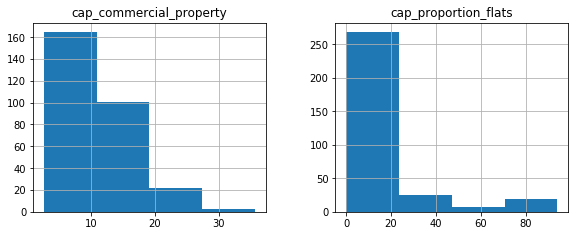

<IPython.core.display.Javascript object>

In [23]:
# cap outliers using 1% and 99% percentiles
commercial_property_percentiles = (
    df_explore["commercial_property"].quantile([0.01, 0.99]).values
)
df_explore["cap_commercial_property"] = np.clip(
    df["commercial_property"],
    commercial_property_percentiles[0],
    commercial_property_percentiles[1],
)

proportion_flats_percentiles = (
    df_explore["proportion_flats"].quantile([0.01, 0.99]).values
)
df_explore["cap_proportion_flats"] = np.clip(
    df_explore["proportion_flats"],
    proportion_flats_percentiles[0],
    proportion_flats_percentiles[1],
)
df_explore[["cap_commercial_property", "cap_proportion_flats"]].hist(
    bins=4, figsize=(15, 8), layout=(2, 3)
)
plt.show()

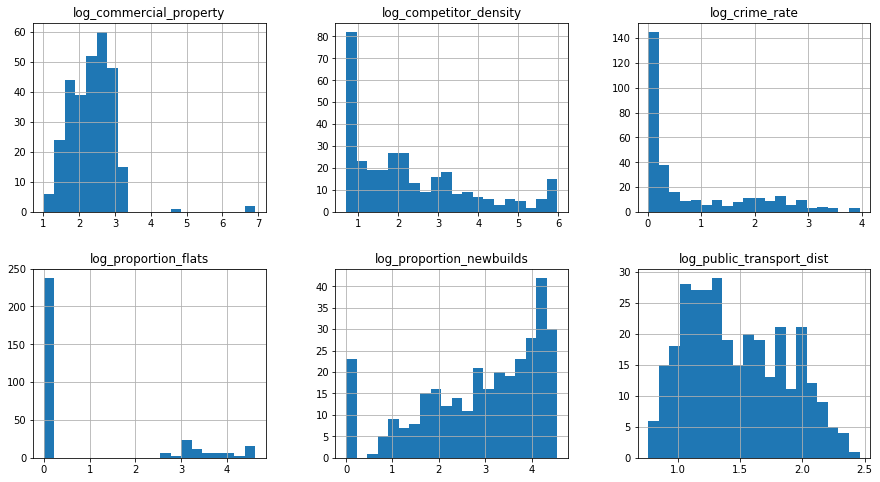

<IPython.core.display.Javascript object>

In [24]:
# apply log transformations to try and bring out stronger relationships
df_explore["log_commercial_property"] = df_explore["commercial_property"].apply(
    np.log1p
)
df_explore["log_competitor_density"] = (
    (df_explore["competitor_density"].max() + 1) - df_explore["competitor_density"]
).apply(np.log1p)
df_explore["log_crime_rate"] = df_explore["crime_rate"].apply(np.log1p)
df_explore["log_proportion_flats"] = df_explore["proportion_flats"].apply(np.log1p)
df_explore["log_proportion_newbuilds"] = df_explore["proportion_newbuilds"].apply(
    np.log1p
)
df_explore["log_public_transport_dist"] = df_explore["public_transport_dist"].apply(
    np.log1p
)
df_explore[
    [
        "log_commercial_property",
        "log_competitor_density",
        "log_crime_rate",
        "log_proportion_flats",
        "log_proportion_newbuilds",
        "log_public_transport_dist",
    ]
].hist(bins=20, figsize=(15, 8), layout=(2, 3))
plt.show()

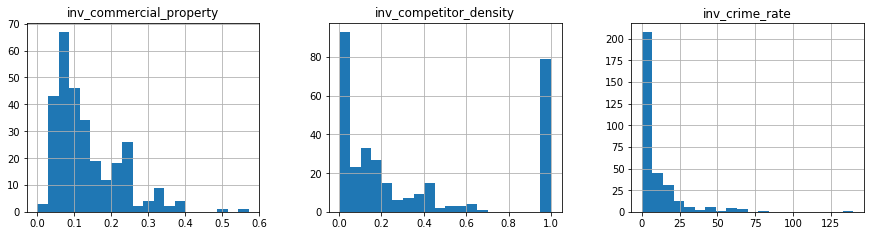

<IPython.core.display.Javascript object>

In [25]:
# try inverse transformation where log transform hasn't achieved the desired results
df_explore["inv_commercial_property"] = df_explore["commercial_property"].apply(
    np.reciprocal
)
df_explore["inv_competitor_density"] = (
    (df_explore["competitor_density"].max() + 1) - df_explore["competitor_density"]
).apply(np.reciprocal)
df_explore["inv_crime_rate"] = df_explore["crime_rate"].apply(np.reciprocal)
df_explore[
    ["inv_commercial_property", "inv_competitor_density", "inv_crime_rate"]
].hist(bins=20, figsize=(15, 8), layout=(2, 3))
plt.show()